# Ex 2 - Transfer learning
##### Group: 11
###### Student 1:  Patrick Koller
###### Student 2:  Yohanes Sugiarto
###### Student 3:  Florian Merz

In [8]:
drive.mount('/content/drive')
CHECKPOINT_FILE_PREFIX = '/content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from sklearn.metrics import accuracy_score

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [11]:
from IPython.core.debugger import set_trace
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load the Dataset and visualize it

In [12]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete8PB9V7/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete8PB9V7/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [13]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

In [14]:
# This step takes too much time. It is not madatory to execute it.
print("Training samples: %d" % train_ds.reduce(0, lambda x,_: x+1).numpy())
print("Validation samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())
print("Tests samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())

Training samples: 15000
Validation samples: 2514
Tests samples: 2514


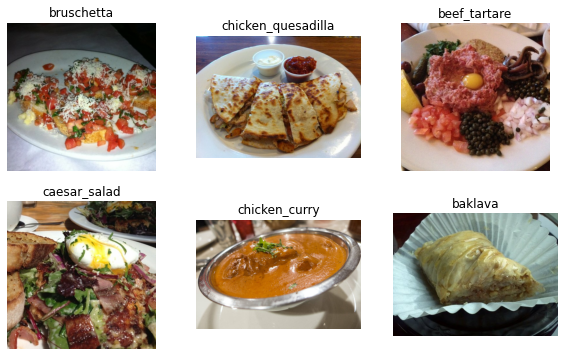

In [15]:
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [16]:
def print_shape(msg): 
  for img,_ in train_ds.take(1): print(msg, img.shape)

def print_sample(msg): 
  for img,_ in train_ds.take(1): print(msg, img[0,0,:])

def print_label(msg): 
  for _,label in train_ds.take(1): print(msg, label)

In [17]:
# TODO Resize the images in the training, validation and test set
def img_resize(img, label):
  img = tf.image.resize(img, [160, 160])
  return img, label

print_shape("OLD Shape:")

train_ds = train_ds.map(img_resize)
validation_ds = validation_ds.map(img_resize)
test_ds = test_ds.map(img_resize)

print_shape("NEW Shape:")

OLD Shape: (512, 512, 3)
NEW Shape: (160, 160, 3)


In [18]:
# Normalize the images
def img_normalize(img, label):
  img = tf.keras.applications.mobilenet.preprocess_input(img)
  return img, label

print_sample("OLD Sample:")

train_ds = train_ds.map(img_normalize)
validation_ds = validation_ds.map(img_normalize)
test_ds = test_ds.map(img_normalize)

print_sample("NEW Sample:")

OLD Sample: tf.Tensor([11.9 11.9 11.9], shape=(3,), dtype=float32)
NEW Sample: tf.Tensor([-0.90666664 -0.90666664 -0.90666664], shape=(3,), dtype=float32)


In [19]:
# One hot encode the labels
def label_one_hot(img, label):
  label = tf.one_hot(label, N_CLASSES)
  return img, label

print_label("OLD Label:")

train_ds = train_ds.map(label_one_hot)
validation_ds = validation_ds.map(label_one_hot)
test_ds = test_ds.map(label_one_hot)

print_label("NEW Label:")

OLD Label: tf.Tensor(10, shape=(), dtype=int64)
NEW Label: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(20,), dtype=float32)


In [20]:
# autotune prefetch buffer
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Data-Augmentation

In [21]:
# Optional define/implements data-augmentation
data_augmentation = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  keras.layers.experimental.preprocessing.RandomContrast(0.1),
  keras.layers.experimental.preprocessing.RandomZoom(0.01),
  # keras.layers.experimental.preprocessing.RandomHeight(0.1),
  # keras.layers.experimental.preprocessing.RandomWidth(0.1),
  keras.layers.experimental.preprocessing.RandomRotation(0.2),
  # keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

## Training
### Step 1: Only train the head of the network

In [22]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

CHECKPOINT_FILE_FREEZE = CHECKPOINT_FILE_PREFIX + '_freeze.h5'

base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(160, 160, 3))

# Freeze the base_model
base_model.trainable = False

# Create the model structure
model = tf.keras.Sequential([
  keras.layers.Input((160, 160, 3)),
  data_augmentation,
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1024),
  keras.layers.Activation('relu'),
  keras.layers.Dense(N_CLASSES, activation='softmax')
])

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                20500     
Total params: 3,590,228
Trainable params: 1,332,244
Non-t

In [23]:
%%time

EPOCHS = 1000
BATCH_SIZE = 32

# Compile the model with your optimizer, your loss and your metrics
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy'])

# Optional: Define and use callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_FILE_FREEZE,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1
)

 # You should us a relatively big learning rate: 1e-3
step1_history = model.fit(
    train_ds.batch(BATCH_SIZE),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_ds.batch(BATCH_SIZE),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/1000
469/469 [==============================] - 206s 365ms/step - loss: 1.7879 - accuracy: 0.4625 - val_loss: 1.1758 - val_accuracy: 0.6309

Epoch 00001: val_accuracy improved from -inf to 0.63087, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_freeze.h5
Epoch 2/1000
469/469 [==============================] - 99s 211ms/step - loss: 1.2099 - accuracy: 0.6225 - val_loss: 1.1337 - val_accuracy: 0.6436

Epoch 00002: val_accuracy improved from 0.63087 to 0.64360, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_freeze.h5
Epoch 3/1000
469/469 [==============================] - 99s 210ms/step - loss: 1.0758 - accuracy: 0.6617 - val_loss: 1.0919 - val_accuracy: 0.6635

Epoch 00003: val_accuracy improved from 0.64360 to 0.66348, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_freeze.h5
Epoch 4/1000
469/469 [==============================] - 98s 209ms/step - loss: 0.9723 - accuracy: 0.6974 - val_loss: 1.0979 - val_accur

In [24]:
# reload best weights
model.load_weights(CHECKPOINT_FILE_FREEZE)

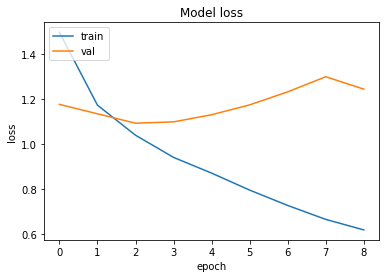

In [25]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(step1_history, 'loss')

### Step 2: Fine-Tune the whole model

In [26]:
CHECKPOINT_FILE_FINETUNING = CHECKPOINT_FILE_PREFIX + '_finetuning.h5'

# Unfreeze the pretrained base.
base_model.trainable = True

# set BatchNormalization layers to inference mode
for l in base_model.layers:
  if isinstance(l, keras.layers.BatchNormalization):
    l.trainable=False

print(model.summary())

# Compile the model again
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                20500     
Total params: 3,590,228
Trainable params: 3,522,004
Non-trainable params: 68,224
_______________________________________

In [27]:
%%time

EPOCHS = 1000
BATCH_SIZE = 32

# Retrain the model
# Optional: Define and use callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_FILE_FINETUNING,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1
)

 # You should us a small learning rate: for example 1e-5 or 1e-6
step2_history = model.fit(
    train_ds.batch(BATCH_SIZE),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_ds.batch(BATCH_SIZE),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/1000
469/469 [==============================] - 122s 251ms/step - loss: 0.8896 - accuracy: 0.7191 - val_loss: 1.0561 - val_accuracy: 0.6913

Epoch 00001: val_accuracy improved from -inf to 0.69133, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_finetuning.h5
Epoch 2/1000
469/469 [==============================] - 117s 249ms/step - loss: 0.7690 - accuracy: 0.7543 - val_loss: 0.9630 - val_accuracy: 0.7140

Epoch 00002: val_accuracy improved from 0.69133 to 0.71400, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_finetuning.h5
Epoch 3/1000
469/469 [==============================] - 117s 250ms/step - loss: 0.7047 - accuracy: 0.7755 - val_loss: 0.9422 - val_accuracy: 0.7192

Epoch 00003: val_accuracy improved from 0.71400 to 0.71917, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_finetuning.h5
Epoch 4/1000
469/469 [==============================] - 116s 248ms/step - loss: 0.6482 - accuracy: 0.7891 - val_loss: 0.9

In [28]:
# reload best weights
model.load_weights(CHECKPOINT_FILE_FINETUNING)

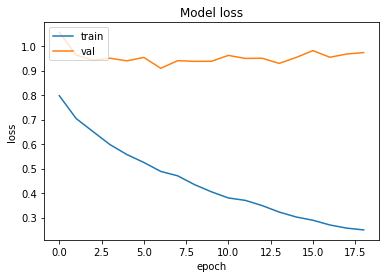

In [29]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [30]:
%%time
BATCH_SIZE = 256

# Predict the test set
y_pred = model.predict(test_ds.batch(BATCH_SIZE), verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds.batch(BATCH_SIZE)], axis=0)

10/10 [==============================] - 31s 3s/step
CPU times: user 48.8 s, sys: 2.94 s, total: 51.7 s
Wall time: 44.1 s


In [31]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7578439259855189
CPU times: user 2.99 ms, sys: 6 µs, total: 3 ms
Wall time: 7.51 ms


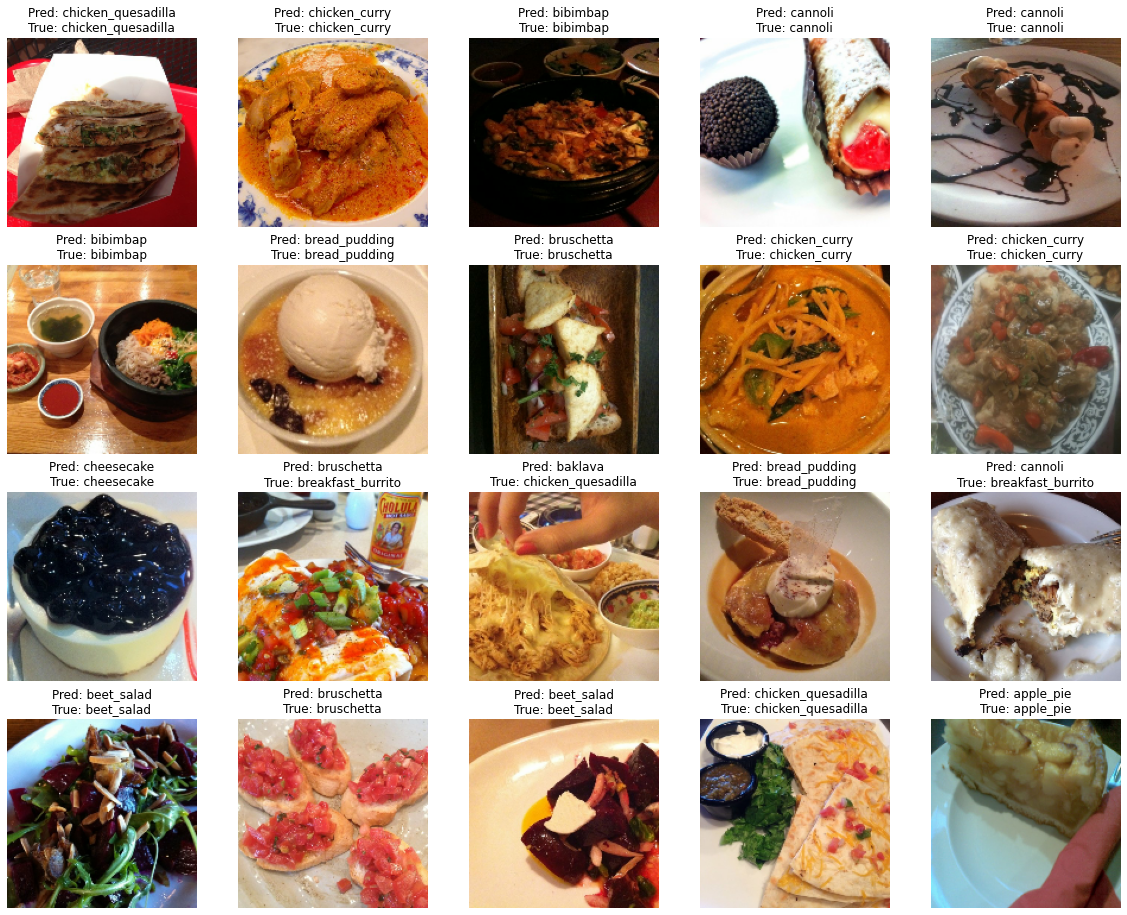

In [32]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds.batch(BATCH_SIZE)])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)

# Add batch-normalization and dropout

In [33]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

CHECKPOINT_FILE_FREEZE = CHECKPOINT_FILE_PREFIX + '_freeze2.h5'

base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(160, 160, 3))

# Freeze the base_model
base_model.trainable = False

# Create the model structure
model = tf.keras.Sequential([
  keras.layers.Input((160, 160, 3)),
  data_augmentation,
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1024),
  keras.layers.BatchNormalization(trainable=False), # set to inference mode
  keras.layers.Activation('relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(N_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)             

In [34]:
%%time

EPOCHS = 1000
BATCH_SIZE = 32

# Compile the model with your optimizer, your loss and your metrics
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy'])

# Optional: Define and use callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_FILE_FREEZE,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1
)

 # You should us a relatively big learning rate: 1e-3
step1_history = model.fit(
    train_ds.batch(BATCH_SIZE),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_ds.batch(BATCH_SIZE),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/1000
469/469 [==============================] - 138s 288ms/step - loss: 2.0521 - accuracy: 0.4011 - val_loss: 1.1482 - val_accuracy: 0.6337

Epoch 00001: val_accuracy improved from -inf to 0.63365, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_freeze2.h5
Epoch 2/1000
469/469 [==============================] - 124s 264ms/step - loss: 1.4304 - accuracy: 0.5670 - val_loss: 1.0581 - val_accuracy: 0.6651

Epoch 00002: val_accuracy improved from 0.63365 to 0.66508, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_freeze2.h5
Epoch 3/1000
469/469 [==============================] - 116s 247ms/step - loss: 1.3284 - accuracy: 0.5879 - val_loss: 1.0402 - val_accuracy: 0.6651

Epoch 00003: val_accuracy did not improve from 0.66508
Epoch 4/1000
469/469 [==============================] - 106s 226ms/step - loss: 1.2648 - accuracy: 0.6115 - val_loss: 1.0321 - val_accuracy: 0.6738

Epoch 00004: val_accuracy improved from 0.66508 to 0.67383, saving m

In [35]:
# reload best weights
model.load_weights(CHECKPOINT_FILE_FREEZE)

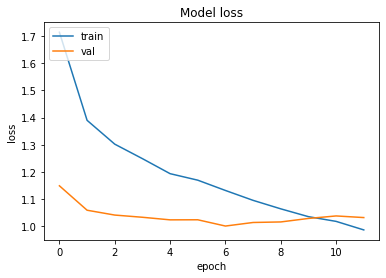

In [36]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(step1_history, 'loss')

In [37]:
CHECKPOINT_FILE_FINETUNING = CHECKPOINT_FILE_PREFIX + '_finetuning2.h5'

# Unfreeze the pretrained base.
base_model.trainable = True

# set BatchNormalization layers to inference mode
for l in base_model.layers:
  if isinstance(l, keras.layers.BatchNormalization):
    l.trainable=False

print(model.summary())

# Compile the model again
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)             

In [38]:
%%time

EPOCHS = 1000
BATCH_SIZE = 32

# Retrain the model
# Optional: Define and use callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_FILE_FINETUNING,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1
)

 # You should us a small learning rate: for example 1e-5 or 1e-6
step2_history = model.fit(
    train_ds.batch(BATCH_SIZE),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_ds.batch(BATCH_SIZE),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/1000
469/469 [==============================] - 140s 290ms/step - loss: 1.0700 - accuracy: 0.6655 - val_loss: 0.9525 - val_accuracy: 0.7017

Epoch 00001: val_accuracy improved from -inf to 0.70167, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_finetuning2.h5
Epoch 2/1000
469/469 [==============================] - 136s 290ms/step - loss: 0.9715 - accuracy: 0.6971 - val_loss: 0.9408 - val_accuracy: 0.7096

Epoch 00002: val_accuracy improved from 0.70167 to 0.70963, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_finetuning2.h5
Epoch 3/1000
469/469 [==============================] - 133s 284ms/step - loss: 0.9008 - accuracy: 0.7146 - val_loss: 0.8953 - val_accuracy: 0.7216

Epoch 00003: val_accuracy improved from 0.70963 to 0.72156, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_finetuning2.h5
Epoch 4/1000
469/469 [==============================] - 120s 256ms/step - loss: 0.8390 - accuracy: 0.7360 - val_loss: 

In [39]:
# reload best weights
model.load_weights(CHECKPOINT_FILE_FINETUNING)

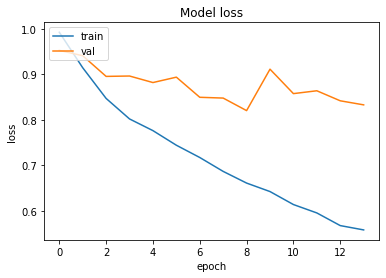

In [40]:
plot_history(step2_history, 'loss')

In [41]:
%%time
BATCH_SIZE = 256

# Predict the test set
y_pred = model.predict(test_ds.batch(BATCH_SIZE), verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds.batch(BATCH_SIZE)], axis=0)

10/10 [==============================] - 14s 1s/step
CPU times: user 49.2 s, sys: 2.57 s, total: 51.7 s
Wall time: 27.1 s


In [42]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7582461786001609
CPU times: user 883 µs, sys: 0 ns, total: 883 µs
Wall time: 924 µs


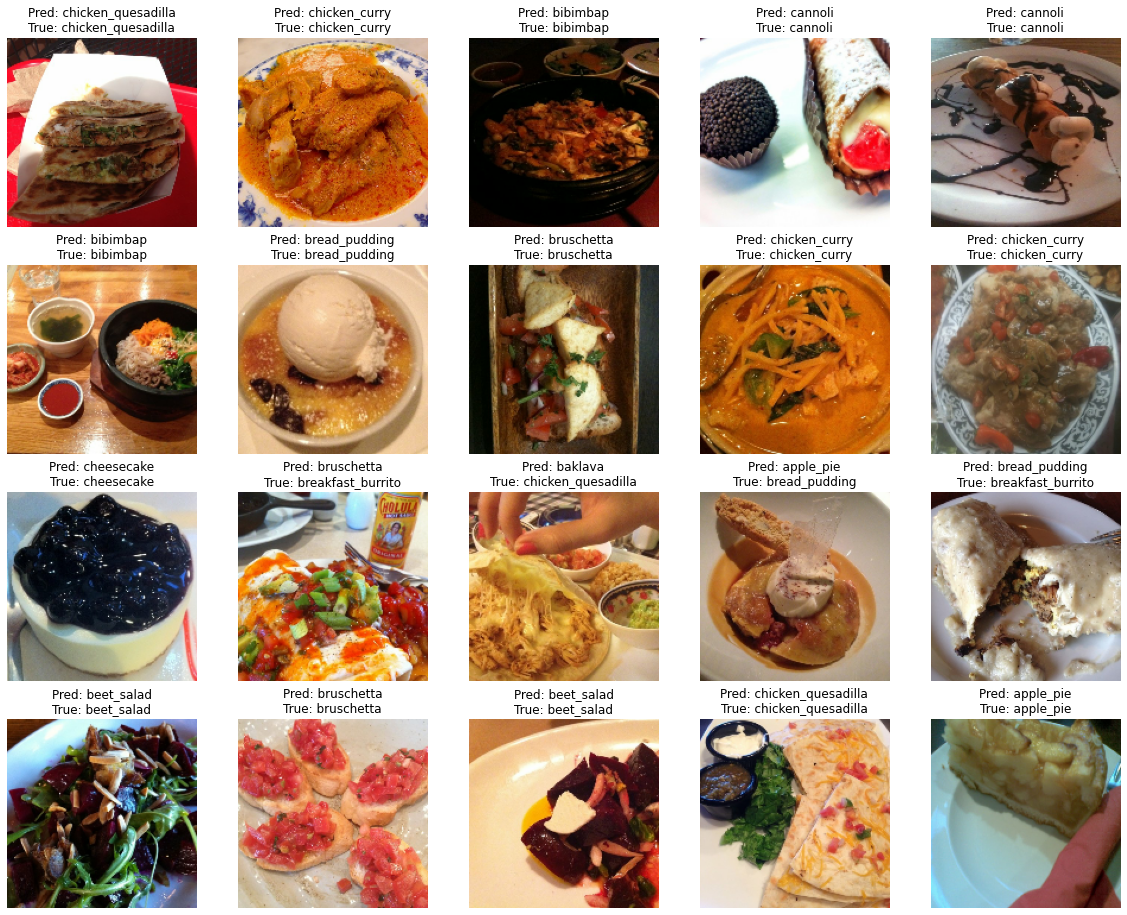

In [43]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds.batch(BATCH_SIZE)])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)

# Add additional dense layer

In [44]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

CHECKPOINT_FILE_FREEZE = CHECKPOINT_FILE_PREFIX + '_freeze3.h5'

base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(160, 160, 3))

# Freeze the base_model
base_model.trainable = False

# Create the model structure
model = tf.keras.Sequential([
  keras.layers.Input((160, 160, 3)),
  data_augmentation,
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1024),
  keras.layers.BatchNormalization(trainable=False), # set to inference mode
  keras.layers.Activation('relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1024),
  keras.layers.BatchNormalization(trainable=False), # set to inference mode
  keras.layers.Activation('relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(N_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

In [45]:
%%time

EPOCHS = 1000
BATCH_SIZE = 32

# Compile the model with your optimizer, your loss and your metrics
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy'])

# Optional: Define and use callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_FILE_FREEZE,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1
)

 # You should us a relatively big learning rate: 1e-3
step1_history = model.fit(
    train_ds.batch(BATCH_SIZE),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_ds.batch(BATCH_SIZE),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/1000
469/469 [==============================] - 104s 215ms/step - loss: 2.2486 - accuracy: 0.3315 - val_loss: 1.2742 - val_accuracy: 0.6082

Epoch 00001: val_accuracy improved from -inf to 0.60819, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_freeze3.h5
Epoch 2/1000
469/469 [==============================] - 101s 215ms/step - loss: 1.6117 - accuracy: 0.5120 - val_loss: 1.1744 - val_accuracy: 0.6408

Epoch 00002: val_accuracy improved from 0.60819 to 0.64081, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_freeze3.h5
Epoch 3/1000
469/469 [==============================] - 101s 215ms/step - loss: 1.5112 - accuracy: 0.5405 - val_loss: 1.1064 - val_accuracy: 0.6675

Epoch 00003: val_accuracy improved from 0.64081 to 0.66746, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_freeze3.h5
Epoch 4/1000
469/469 [==============================] - 101s 215ms/step - loss: 1.4547 - accuracy: 0.5631 - val_loss: 1.1047 - val

In [46]:
# reload best weights
model.load_weights(CHECKPOINT_FILE_FREEZE)

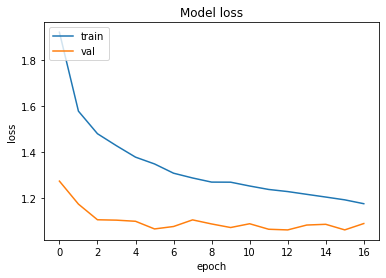

In [47]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(step1_history, 'loss')

In [48]:
CHECKPOINT_FILE_FINETUNING = CHECKPOINT_FILE_PREFIX + '_finetuning3.h5'

# Unfreeze the pretrained base.
base_model.trainable = True

# set BatchNormalization layers to inference mode
for l in base_model.layers:
  if isinstance(l, keras.layers.BatchNormalization):
    l.trainable=False

print(model.summary())

# Compile the model again
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

In [49]:
%%time

EPOCHS = 1000
BATCH_SIZE = 32

# Retrain the model
# Optional: Define and use callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_FILE_FINETUNING,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1
)

 # You should us a small learning rate: for example 1e-5 or 1e-6
step2_history = model.fit(
    train_ds.batch(BATCH_SIZE),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_ds.batch(BATCH_SIZE),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/1000
469/469 [==============================] - 123s 255ms/step - loss: 1.2008 - accuracy: 0.6429 - val_loss: 1.0373 - val_accuracy: 0.6969

Epoch 00001: val_accuracy improved from -inf to 0.69690, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_finetuning3.h5
Epoch 2/1000
469/469 [==============================] - 119s 253ms/step - loss: 1.1214 - accuracy: 0.6617 - val_loss: 0.9976 - val_accuracy: 0.7068

Epoch 00002: val_accuracy improved from 0.69690 to 0.70684, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_finetuning3.h5
Epoch 3/1000
469/469 [==============================] - 120s 255ms/step - loss: 1.0613 - accuracy: 0.6791 - val_loss: 0.9352 - val_accuracy: 0.7299

Epoch 00003: val_accuracy improved from 0.70684 to 0.72991, saving model to /content/drive/MyDrive/TSM_DeLearn/ex10/ex2_checkpoint_finetuning3.h5
Epoch 4/1000
469/469 [==============================] - 119s 253ms/step - loss: 1.0165 - accuracy: 0.6924 - val_loss: 

In [50]:
# reload best weights
model.load_weights(CHECKPOINT_FILE_FINETUNING)

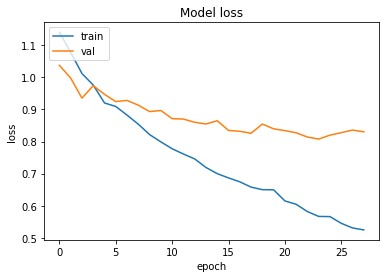

In [51]:
plot_history(step2_history, 'loss')

In [52]:
%%time
BATCH_SIZE = 256

# Predict the test set
y_pred = model.predict(test_ds.batch(BATCH_SIZE), verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds.batch(BATCH_SIZE)], axis=0)

10/10 [==============================] - 14s 1s/step
CPU times: user 49.3 s, sys: 2.49 s, total: 51.8 s
Wall time: 27.1 s


In [53]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7650844730490748
CPU times: user 1.1 ms, sys: 843 µs, total: 1.94 ms
Wall time: 1.98 ms


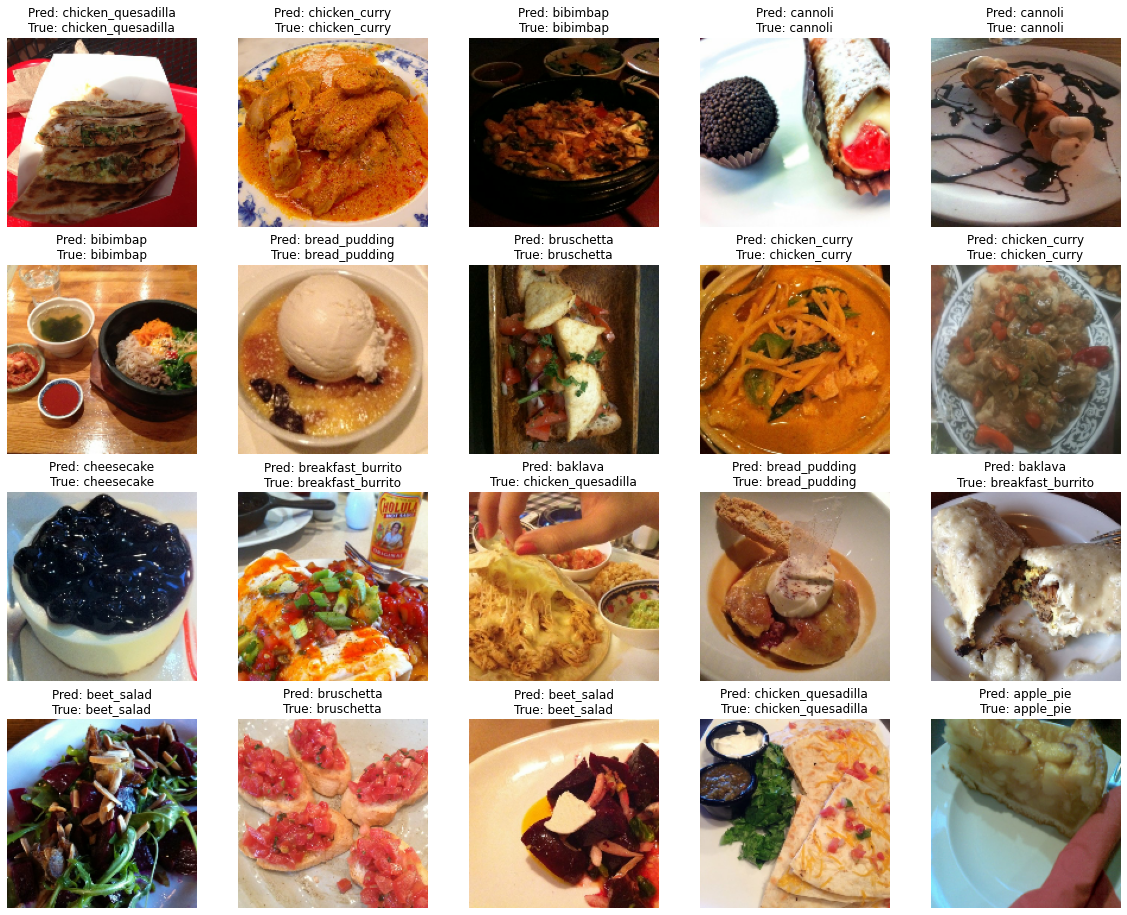

In [54]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds.batch(BATCH_SIZE)])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)

| Model | Architecture description            | Callback | Acc. test | Params    | Training time | Fine-tune time |
|-------|-------------------------------------|----------|-----------| --------- | ------------- | -------------- |
|  1    | Base model                          | Yes      | 0.7578    | 3,590,228 | 16min 37s     | 37min 27s      |
|  2    | Add batch-normalization and dropout | Yes      | 0.7582    | 3,594,324 | 22min 24s     | 30min 53s      |
|  3    | Add additional dense layer          | Yes      | 0.7651    | 4,648,020 | 28min 41s     | 56min 6s       |

Base model:
mobilenetv2 -> global_average_pooling2d -> Dense -> ReLu -> Dense -> Softmax